### Aumento de Datos

El **aumento de datos** (*data augmentation*) es una técnica crucial en el aprendizaje automático que se utiliza para incrementar y diversificar el conjunto de datos disponible para el entrenamiento de modelos. Consiste en aplicar una serie de transformaciones a los datos originales para crear nuevas muestras, enriqueciendo así el conjunto de entrenamiento.

**Transformaciones comunes en el aumento de datos incluyen:**

- **Rotación**: Gira las imágenes en diversos ángulos, aportando variabilidad en la orientación.
- **Escalado**: Ajusta el tamaño de las imágenes, permitiendo que el modelo aprenda a reconocer objetos a diferentes escalas.
- **Recorte**: Extrae secciones específicas de las imágenes, simulando distintos enfoques o detalles variados.
- **Cambio de color**: Modifica los valores de color o el contraste para simular diferentes condiciones de iluminación o color.
- **Flip horizontal/vertical**: Invierte las imágenes horizontal o verticalmente, ayudando a captar variaciones en la perspectiva.

El objetivo del aumento de datos es **mejorar la capacidad de generalización** del modelo, **reducir el sobreajuste** y aumentar su robustez ante variaciones en los datos. Esta técnica es particularmente útil cuando se dispone de un conjunto de datos limitado, ya que permite al modelo aprender de una gama más amplia de ejemplos y situaciones.



# Librerias

In [2]:
import os
import random
from PIL import Image, ImageEnhance
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import pandas as pd
import shutil
from tqdm import tqdm
from pathlib import Path

# Ruta de la dataset

In [3]:

data_potato = Path('../data/processed/manual')

# Definir categorias

In [4]:
categories1 = os.listdir(data_potato)


In [5]:
# Función para cargar y mostrar  imágenes por categoría 
def show_sample_images_pil(data_dir, categories, num_samples=5):
    for category in categories:
        category_path = os.path.join(data_dir, category)
        images = os.listdir(category_path)[:num_samples]  

        print(f"Mostrando imágenes de la categoría: {category}")
        
        # Mostrar las imágenes
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
        for i, img_file in enumerate(images):
            img_path = os.path.join(category_path, img_file)

            try:
                img = Image.open(img_path)  
                axes[i].imshow(img)
                axes[i].set_title(f"{category} {i+1}")
                axes[i].axis('off')
            except Exception as e:
                print(f"Error al cargar la imagen: {img_path}. Error: {e}")
                axes[i].axis('off')

        plt.show()


Mostrando imágenes de la categoría: Daños por nematodos


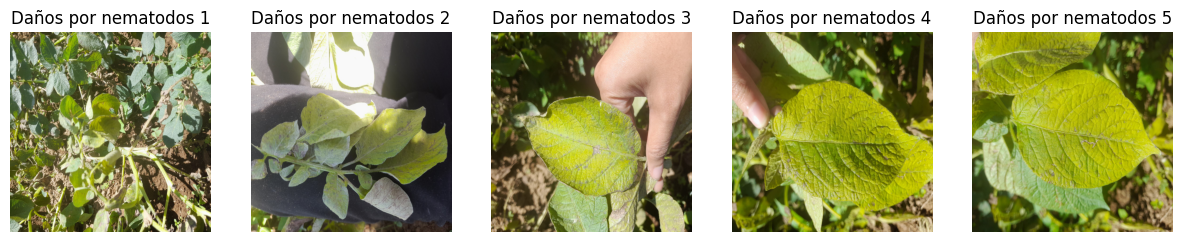

Mostrando imágenes de la categoría: Daños por plagas


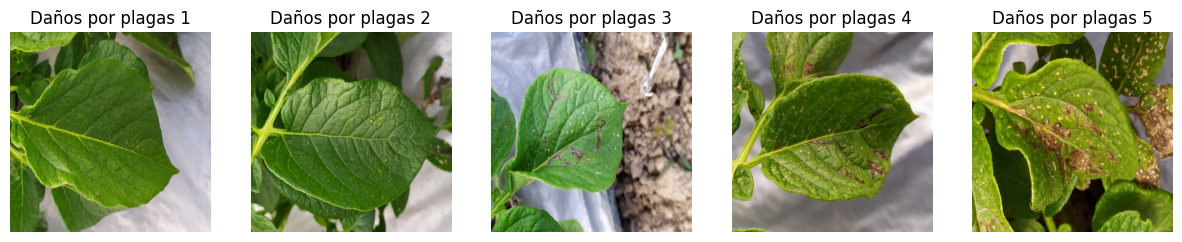

Mostrando imágenes de la categoría: Enfermedades bacterianas


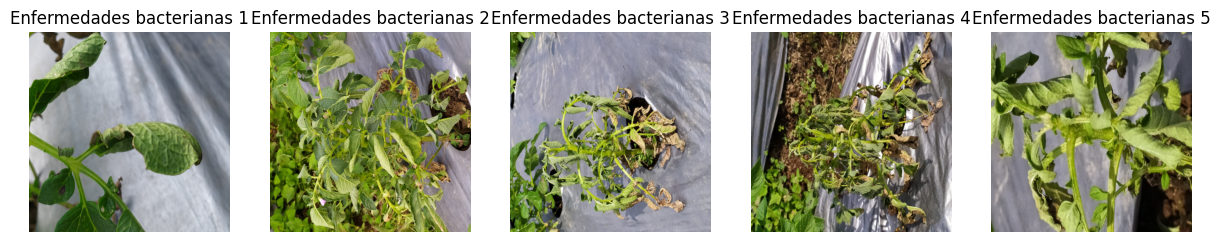

Mostrando imágenes de la categoría: Enfermedades fúngicas


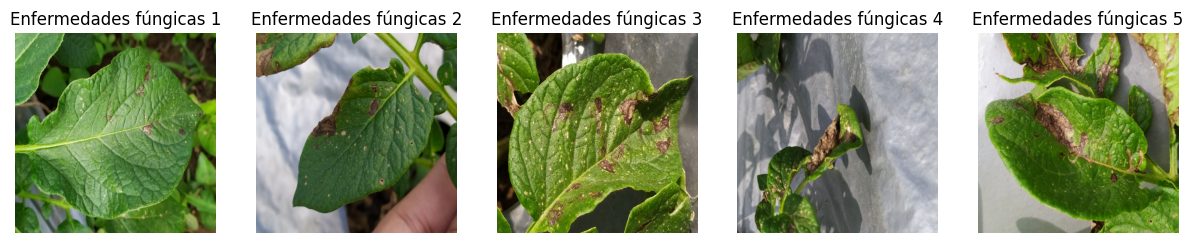

Mostrando imágenes de la categoría: Enfermedades virales


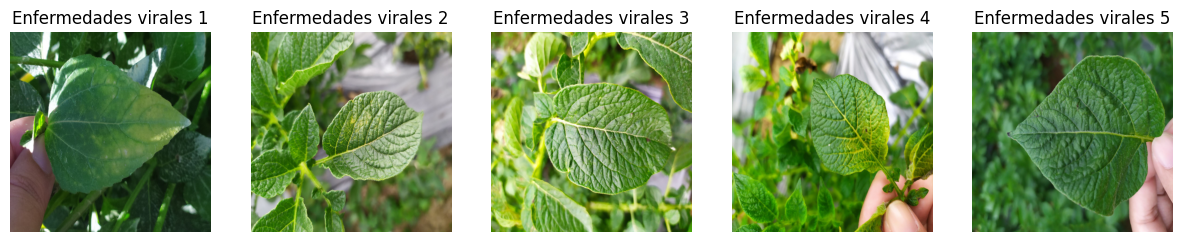

Mostrando imágenes de la categoría: Salud


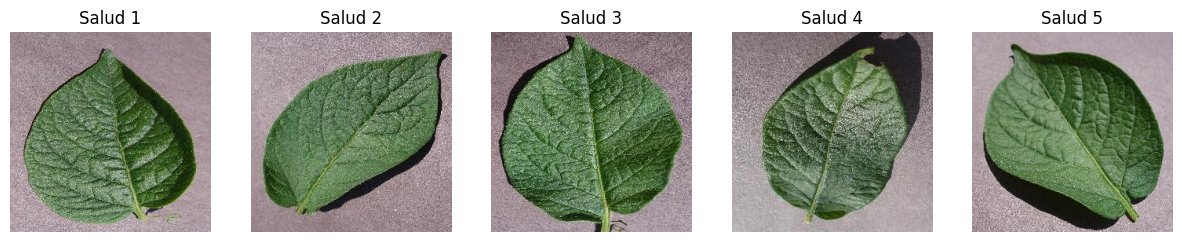

Mostrando imágenes de la categoría: Tizón tardío (Phytophthora)


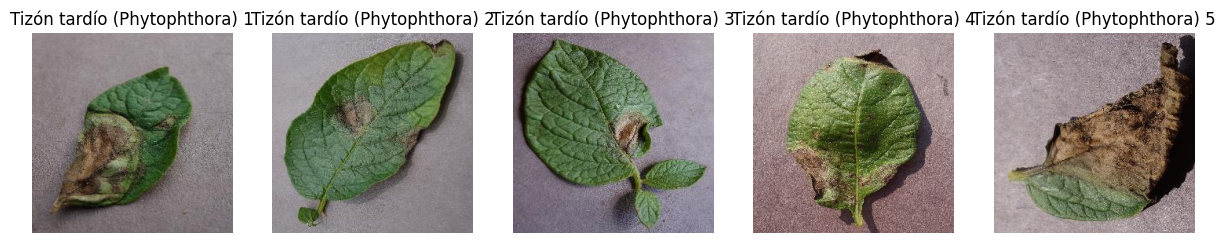

Mostrando imágenes de la categoría: Tizón temprano


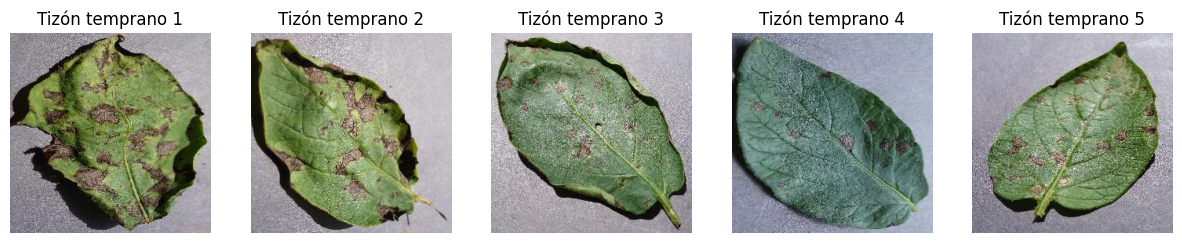

In [6]:
# Mostrar imágenes 
show_sample_images_pil(data_potato, categories1)

In [7]:
# Funcion para contar la cantidad de datoa por categoria
def count_images_in_categories(data_dir):
    # Listar todas las categorías
    categories = os.listdir(data_dir)
    category_counts = {}
    
    for category in categories:
        category_path = os.path.join(data_dir, category)
        if os.path.isdir(category_path):
            # Contar los archivos en cada subcarpeta
            count = len(os.listdir(category_path))
            category_counts[category] = count
    
    # Convertir el diccionario en un DataFrame
    df = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])
    return df


# Resumen de cuadro estadistico del dataset

In [8]:
data = count_images_in_categories(data_potato)
data

Category  Count
0          Daños por nematodos    568
1             Daños por plagas   1111
2     Enfermedades bacterianas    569
3        Enfermedades fúngicas   1248
4         Enfermedades virales   1032
5                        Salud    852
6  Tizón tardío (Phytophthora)   1316
7               Tizón temprano   1424

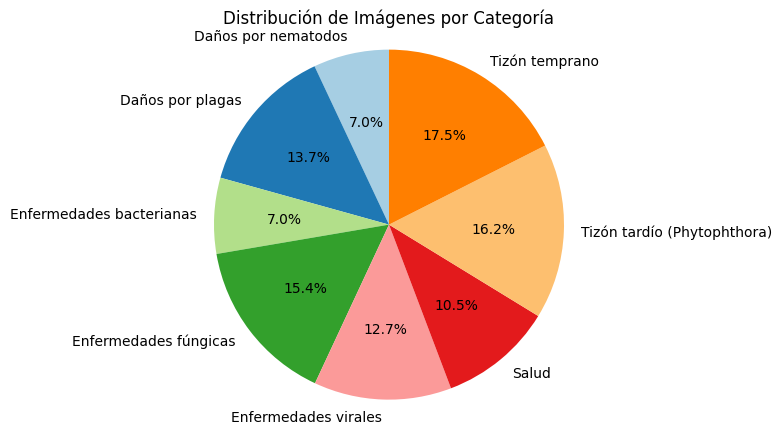

In [9]:


plt.figure(figsize=(8, 5))
plt.pie(data['Count'], labels=data['Category'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired(range(len(data['Category']))))
plt.title('Distribución de Imágenes por Categoría')
# Mostrar gráfico
plt.axis('equal') 
plt.show()


# Funciones para  aplicar data augmentation

## 

In [32]:

# Funciones de augmentación
def random_rotation(image):
    return image.rotate(random.choice([90, 180, 270]))

def random_scaling(image):
    scale_factor = random.uniform(0.8, 1.2)
    new_size = (int(image.width * scale_factor), int(image.height * scale_factor))
    return image.resize(new_size, Image.LANCZOS)

def random_cropping(image):
    crop_percent = random.uniform(0.9, 1.0)
    width, height = image.size
    new_width = int(width * crop_percent)
    new_height = int(height * crop_percent)
    left = random.randint(0, width - new_width)
    top = random.randint(0, height - new_height)
    return image.crop((left, top, left + new_width, top + new_height))

def random_brightness(image):
    enhancer = ImageEnhance.Brightness(image)
    factor = random.uniform(0.7, 1.3)
    return enhancer.enhance(factor)

def random_flip(image):
    if random.choice([True, False]):
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    if random.choice([True, False]):
        image = image.transpose(Image.FLIP_TOP_BOTTOM)
    return image

def apply_augmentation(image):
    augmentations = [random_rotation, random_scaling, random_cropping, random_brightness, random_flip]
    num_augmentations = random.randint(2, len(augmentations))
    selected_augmentations = random.sample(augmentations, num_augmentations)
    
    for augmentation in selected_augmentations:
        image = augmentation(image)
    return image

def copy_and_augment_category(category_path, output_path, target_count=1300):
    output_category_path = output_path / category_path.name
    output_category_path.mkdir(parents=True, exist_ok=True)
    
    image_files = list(category_path.glob('*.[jp][pn]g'))
    current_count = len(image_files)
    
    # Si hay más de 1300 imágenes, cortar el exceso
    if current_count > target_count:
        image_files = image_files[:target_count]
        current_count = target_count
        print(f"Reduciendo la categoría {category_path.name} a {target_count} imágenes.")
    
    # Copiar imágenes originales hasta el límite de 1300
    for img_path in image_files:
        shutil.copy(img_path, output_category_path)
    
    print(f"Copiadas {current_count} imágenes originales para {category_path.name}")
    if current_count >= target_count:
        print(f"La categoría {category_path.name} ya tiene suficientes imágenes ({current_count}).")
        return
    
    augmentations_needed = target_count - current_count
    
    # Aplicar augmentations si es necesario
    for i in tqdm(range(augmentations_needed), desc=f"Aumentando {category_path.name}"):
        original_image_path = random.choice(image_files)
        with Image.open(original_image_path).convert('RGB') as original_image:
            augmented_image = apply_augmentation(original_image)
            new_name = f"aug_{original_image_path.stem}_{i:04d}.jpg"
            augmented_image.save(output_category_path / new_name)




## Creamos la carpeta 

In [33]:
output_base_path = Path('../data/processed/augmented')
target_count = 1300

In [34]:
# Asegurarse de que la carpeta de salida exista
output_base_path.mkdir(parents=True, exist_ok=True)

## Procesamos  el aumento de datos 

In [35]:
print("Iniciando el proceso de copia y aumento de datos para imágenes de patatas")

# Eliminar archivos existentes en la carpeta de salida
if output_base_path.exists() and output_base_path.is_dir():
    shutil.rmtree(output_base_path)  # Eliminar toda la carpeta y su contenido
    output_base_path.mkdir()  # Volver a crear la carpeta vacía

for category in data_potato.iterdir():
    if category.is_dir():
        print(f"\nProcesando categoría: {category.name}")
        copy_and_augment_category(category, output_base_path, target_count)


Iniciando el proceso de copia y aumento de datos para imágenes de patatas

Procesando categoría: Daños por nematodos
Copiadas 526 imágenes originales para Daños por nematodos


Aumentando Daños por nematodos: 100%|██████████| 774/774 [00:06<00:00, 115.59it/s]



Procesando categoría: Daños por plagas
Copiadas 1111 imágenes originales para Daños por plagas


Aumentando Daños por plagas: 100%|██████████| 189/189 [00:05<00:00, 32.52it/s]



Procesando categoría: Enfermedades bacterianas
Copiadas 569 imágenes originales para Enfermedades bacterianas


Aumentando Enfermedades bacterianas: 100%|██████████| 731/731 [00:39<00:00, 18.71it/s]



Procesando categoría: Enfermedades fúngicas
Copiadas 1248 imágenes originales para Enfermedades fúngicas


Aumentando Enfermedades fúngicas: 100%|██████████| 52/52 [00:01<00:00, 37.20it/s]



Procesando categoría: Enfermedades virales
Copiadas 1032 imágenes originales para Enfermedades virales


Aumentando Enfermedades virales: 100%|██████████| 268/268 [00:07<00:00, 37.57it/s]



Procesando categoría: Salud
Copiadas 852 imágenes originales para Salud


Aumentando Salud: 100%|██████████| 448/448 [00:05<00:00, 79.47it/s] 



Procesando categoría: Tizón tardío (Phytophthora)
Reduciendo la categoría Tizón tardío (Phytophthora) a 1300 imágenes.
Copiadas 1300 imágenes originales para Tizón tardío (Phytophthora)
La categoría Tizón tardío (Phytophthora) ya tiene suficientes imágenes (1300).

Procesando categoría: Tizón temprano
Reduciendo la categoría Tizón temprano a 1300 imágenes.
Copiadas 1300 imágenes originales para Tizón temprano
La categoría Tizón temprano ya tiene suficientes imágenes (1300).


# Dataset aumentado con las categorias 

In [36]:
categories_augmented = os.listdir(output_base_path)

In [37]:
data = count_images_in_categories(output_base_path)
data

Category  Count
0          Daños por nematodos   1300
1             Daños por plagas   1300
2     Enfermedades bacterianas   1300
3        Enfermedades fúngicas   1300
4         Enfermedades virales   1300
5                        Salud   1300
6  Tizón tardío (Phytophthora)   1300
7               Tizón temprano   1300

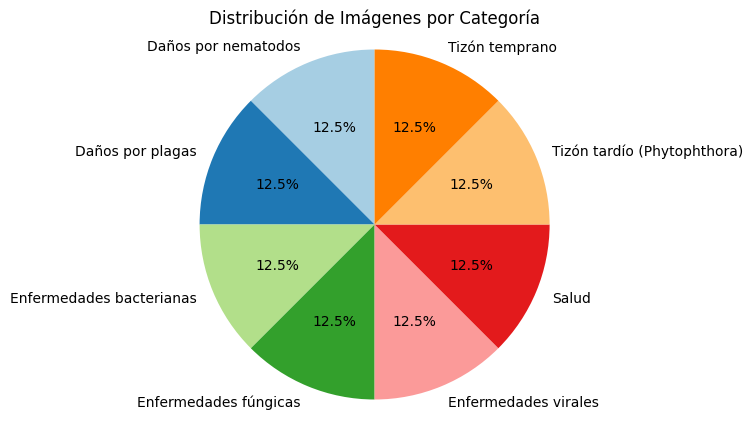

In [38]:
plt.figure(figsize=(8, 5))
plt.pie(data['Count'], labels=data['Category'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired(range(len(data['Category']))))
plt.title('Distribución de Imágenes por Categoría')
# Mostrar gráfico
plt.axis('equal') 
plt.show()

## Funcion para mostrar imagenes

In [39]:
def show_sample_images_pil(data_dir, num_per_row=4):
    categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    num_categories = len(categories)
    num_rows = (num_categories + num_per_row - 1) // num_per_row  # Redondeo hacia arriba

    fig, axes = plt.subplots(num_rows, num_per_row, figsize=(15, 5 * num_rows))
    axes = axes.flatten() if num_rows > 1 else [axes]  # Asegurarse de que axes sea siempre una lista

    for i, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        images = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
        
        if images:
            img_path = os.path.join(category_path, random.choice(images))
            try:
                img = Image.open(img_path)
                axes[i].imshow(img)
                axes[i].set_title(category)
                axes[i].axis('off')
            except Exception as e:
                print(f"Error al cargar la imagen de {category}: {e}")
                axes[i].axis('off')
        else:
            print(f"No se encontraron imágenes en la categoría: {category}")
            axes[i].axis('off')

    # Ocultar los ejes sobrantes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    

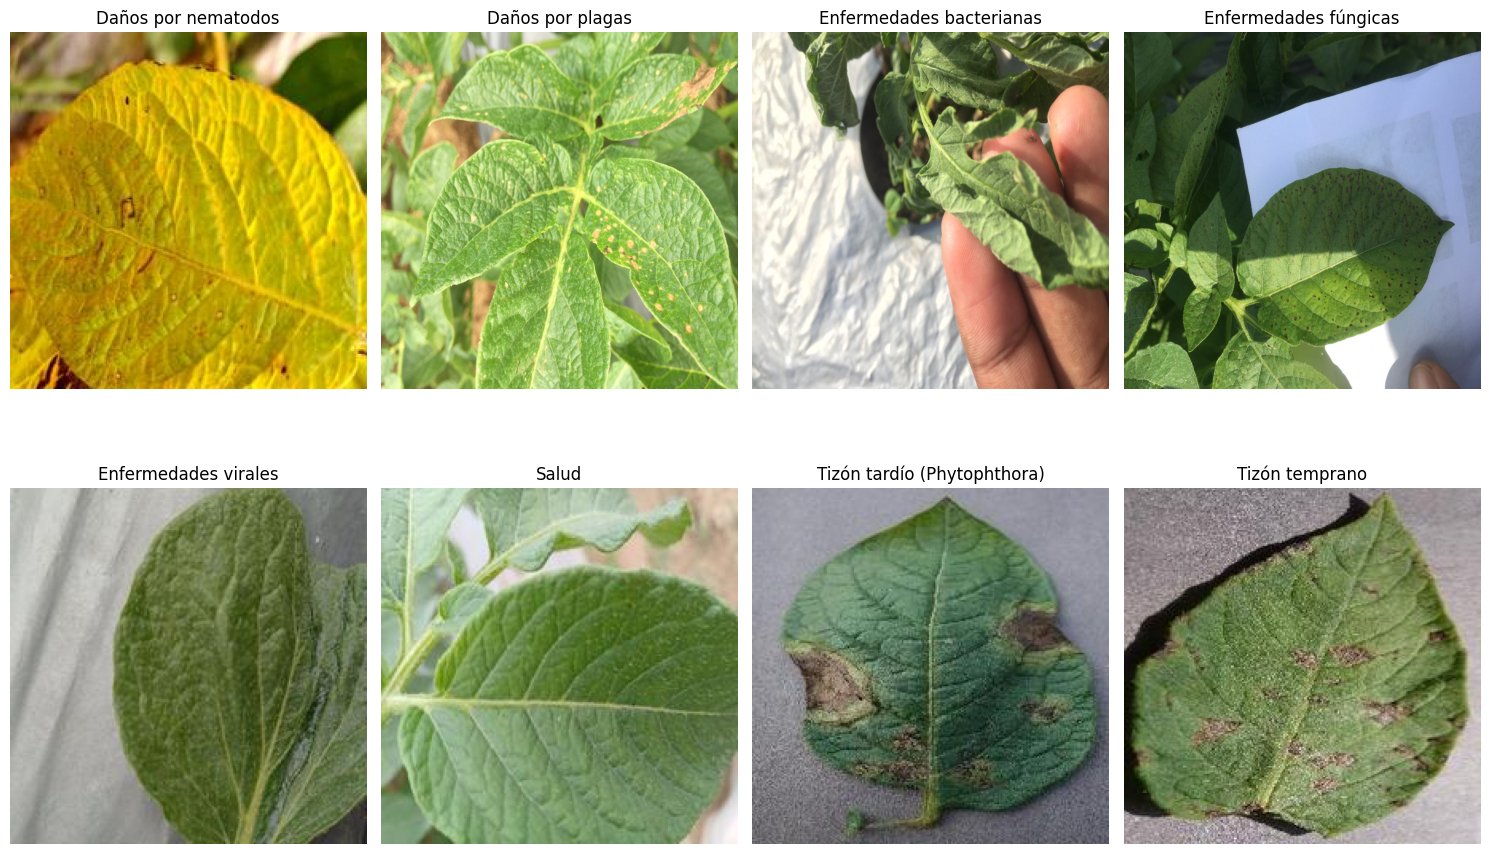

In [41]:

show_sample_images_pil(data_potato )